# Analizando Redes de Colaboração Científica
Para podermos analizar redes de colaboração em publicações científicas, precisamos antes construir um banco de referências. Para isso iremos utilizar [este código](https://github.com/fccoelho/pubmed_downloader/blob/master/fetch2pgsql.py). Este script foi construído como uma ferramenta para a construção de um banco de referências sobre `COVID19` para as análises deste capitulo. Caso o leitor deseje, pode também modificar o script para atender seus interesses pessoais de busca bibliográficas.

Começamos abaixo com uma busca de no máximo 500 artigos por palavra-chave. Esta linha de comando irá gerar um banco de dados chamado `pubmed.sqlite`.

In [ ]:
!./fetch2sql.py --count 500

Fetching results for covid19
Found 500 items
 27%|███████████▏                             | 136/500 [01:48<04:48,  1.26it/s]

### Buscas no Corpus
Este banco de dados foi configurado com indexação automática do seu conteúdo. Logo podemos escrever uma simples função para realizar as buscas:

In [34]:
from sqlalchemy import create_engine, text
from IPython.core.display import display, HTML

In [35]:
def busca(q):
    engine = create_engine(f"sqlite:///pubmed.sqlite")
    with engine.connect() as con:
        res = con.execute(text(f"select rowid, title,highlight(article_fts, 1, '<b>', '</b>') from article_fts('{q}');")).fetchall()
    del engine
    return res

In [36]:
for pmid, title, a in busca('cov2'):
    display(pmid, title, HTML(a))

36499351

'Pathological Roles of Pulmonary Cells in Acute Lung Injury: Lessons from Clinical Practice.'

36501018

'Predictors of Sarcopenia in Outpatients with Post-Critical SARS-CoV2 Disease. Nutritional Ultrasound of Rectus Femoris Muscle, a Potential Tool.'

36503438

'Severe COVID-19-associated myocarditis with cardiogenic shock - management with assist devices - a case report & review.'

36505528

'Seroprevalence of SARS-CoV 2 antibodies & its determinants in children of 5-to-18-year age group in an urban setting, Kerala.'

36506002

'Maternal fructose boosts the effects of a Western-type diet increasing SARS-COV-2 cell entry factors in male offspring.'

36507223

'Ad26.COV2.S priming provided a solid immunological base for mRNA-based COVID-19 booster vaccination.'

36510222

'Longitudinal transcriptional analysis of peripheral blood leukocytes in COVID-19 convalescent donors.'

36510647

"Increased incidence of Graves'' disease during the SARS-CoV2 pandemic."

36511263

'Factors Associated with Vaccine Breakthrough Incidence among Health Care Workers Vaccinated with Inactivated SARS-CoV2 Vaccine (CoronaVac).'

36514704

'Remdesivir-Induced Liver Injury in a Patient With Coronavirus Disease 2019 and History of Congestive Hepatopathy.'

### Redes de Citações
Nosso código de coleta de artigos no PubMed também construiu uma tabela de citações de cada artigo baixado.

In [37]:
import networkx as nx

Vamos começar com um id de artigo que possua citações. Mas antes precisamos escrever uma função para buscar os vizinhos futuros, ou seja, os artigos que os citam.

In [38]:
def get_neighbors(pmid):
    engine = create_engine('sqlite:///pubmed.sqlite',
                                    echo=False)
    sql = f"select cited_by from citations_covid19 where pmid={pmid};"
    res = engine.execute(sql).fetchone()
    if res is not None:
        return res[0].split('|')    

Na função acima, caso não existam citações registradas, a sua saída será `None`.

In [39]:
get_neighbors(36502386)

['36502408', '36496350']

Para construir a rede de citações, vamos usar um objeto fila (queue em inglês) do tipo FIFO (first in, first out). O código abaixo começa por um artigo que será a raiz da rede e o adiciona à fila. Em seguida, usando a função `get_neighbors` acima encontramos os artigos que o citam, criamos arestas na rede e os adicionamos à fila. O loop while repete estas operações até que a fila esteja vazia.

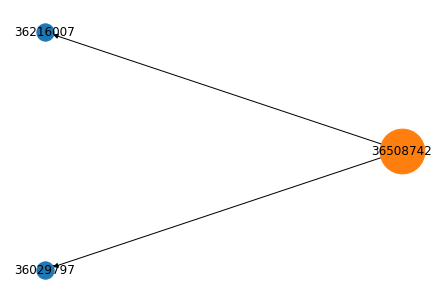

In [44]:
from queue import SimpleQueue
q = SimpleQueue()
raiz = 36508742
q.put(raiz)
árvore = nx.DiGraph()
while True:
    if q.empty():
        break
    nó = q.get()
    vizinhos = get_neighbors(nó)
    if isinstance(vizinhos, list):
        for v in vizinhos:
            árvore.add_edge(nó, v)
            q.put(int(v))
# pos = nx.nx_agraph.graphviz_layout(árvore, prog="twopi", args="")
pos = nx.kamada_kawai_layout(árvore)
nx.draw(árvore, pos, with_labels=True)
nx.draw_networkx_nodes(árvore, pos, node_size=2000, nodelist=[raiz], node_color="tab:orange");

## Estabelecendo um Gerador de Artigos
Como de costume em análise de textos precisamos estabelecer uma metodologia de acesso gradual ao corpus para evitar problemas de consumo excessivo de memória. Neste espírito vamos começar construindo um um gerador que nos entregue um artigo por vez, a partir do nosso banco de dados.

In [45]:
from gensim import utils
from sqlalchemy import create_engine

In [46]:
class StreamCorpus(object):
    def __init__(self, table, limit=100):
        """
        Iterador sobre o corpus no banco SQLite
        :param table: nome da tabela
        :param limit: limite de artigos
        """
        self.engine = create_engine('sqlite:///pubmed.sqlite',
                                    echo=False)
        self.limit = limit
        self.table = table
        self.conn = self.engine.connect()

    @property
    def text_gen(self):
        return (str(text[0]) for text in
                self.conn.execute(f"SELECT abstract FROM {self.table} limit {self.limit}").fetchall() if
                text[0].strip() != '')

    def __iter__(self):
        for doc in self.text_gen:
            yield list(utils.simple_tokenize(doc))
        self.conn.close()


O código acima retorna os resumos tokenizados das referências armazenadas no banco de dados. Vamos examinar alguns destes resumos.

In [47]:
SC = StreamCorpus('covid19', 1000)
i = 0
for abs in SC:
    print (abs)
    if i == 2:
        break
    i += 1


['This', 'article', 'explores', 'the', 'question', 'of', 'why', 'the', 'nine', 'pandemics', 'prior', 'to', 'COVID', 'which', 'have', 'affected', 'millions', 'of', 'people', 'since', 'the', 'second', 'half', 'of', 'the', 'th', 'century', 'were', 'not', 'recorded', 'in', 'collective', 'memory', 'despite', 'their', 'magnitude', 'and', 'extent', 'Thus', 'it', 'proposes', 'a', 'reading', 'of', 'the', 'pandemic', 'as', 'one', 'component', 'of', 'a', 'wider', 'syndemic', 'made', 'up', 'of', 'contagious', 'diseases', 'climate', 'change', 'and', 'malnutrition', 'This', 'piece', 'offers', 'a', 'narrative', 'of', 'the', 'origins', 'development', 'and', 'prospects', 'of', 'the', 'pandemic', 'within', 'the', 'dynamics', 'of', 'the', 'global', 'food', 'system', 'and', 'national', 'economic', 'and', 'political', 'systems', 'highlighting', 'components', 'and', 'connections', 'It', 'includes', 'a', 'warning', 'that', 'along', 'with', 'climate', 'change', 'and', 'malnutrition', 'undernourishment', 'obes

## Construindo Modelos Vetoriais

In [48]:
from gensim.models import Doc2Vec, FastText, KeyedVectors, Word2Vec
from gensim.models.doc2vec import TaggedLineDocument
from gensim.models.word2vec import LineSentence
from gensim.similarities.annoy import AnnoyIndexer
from gensim.utils import save_as_line_sentence

In [49]:
class Embeddings:
    def __init__(self,table_name, filename, corpus_size):
        """
        Create embeddings based on a corpus
        :param filename: file name where the corpus with be temporarily dumped.
        :param corpus_size: number of documents to be used to build the embeddings
        """
        self.table_name = table_name
        self.filename = filename
        self.corpus_size = corpus_size

    def dump_to_corpus_file(self, table_name):
        stream_corpus = StreamCorpus(self.table_name, self.corpus_size)
        save_as_line_sentence(stream_corpus, self.filename)

    def gen_wor2vec(self):
        """
        Build Word2Vec embedding
        :return:
        """
        model = Word2Vec(sentences=LineSentence(self.filename), workers=8)
        model.save(f"{self.filename.split('.')[0]}.w2v")
        return model
    
    def gen_WMD(self):
        model = Word2Vec

    def gen_fasttext(self):
        model = FastText(sentences=LineSentence(self.filename), workers=8)
        model.save(f"{self.filename.split('.')[0]}.ft")
        return model

    def gen_doc2vec(self):
        model = Doc2Vec(documents=TaggedLineDocument(self.filename), workers=8)
        model.save(f"{self.filename.split('.')[0]}.d2v")
        return model

### Modelo Word2Vec

In [50]:
# del SC
E = Embeddings('covid19','articles.txt',1000)
E.dump_to_corpus_file('articles')
mwv = E.gen_wor2vec()

In [51]:
mwv.wv.most_similar('SARS')

[('syndrome', 0.9543189406394958),
 ('respiratory', 0.9537762403488159),
 ('acute', 0.9496352076530457),
 ('infection', 0.9480603337287903),
 ('coronavirus', 0.9478137493133545),
 ('severe', 0.9424639344215393),
 ('disease', 0.918355405330658),
 ('CoV', 0.915025532245636),
 ('corona', 0.914029061794281),
 ('caused', 0.8789240717887878)]

### Modelo "Fast Text"
O modelo Fast text nos permite lidar com variações morfológicas das palavras

In [52]:
E = Embeddings('covid19','articles.txt',1000)
E.dump_to_corpus_file('articles')
mft = E.gen_fasttext()

In [53]:
mft.wv.most_similar('SARS')

[('CoV', 0.9942441582679749),
 ('coronaviruses', 0.9934917092323303),
 ('virus', 0.993304967880249),
 ('infect', 0.9931924343109131),
 ('corona', 0.9928044676780701),
 ('ARS', 0.9926421642303467),
 ('syndrome', 0.9925889372825623),
 ('pseudovirus', 0.9925788640975952),
 ('Syndrome', 0.9924823045730591),
 ('Coronaviridae', 0.9921442270278931)]

### Modelo Doc2Vec
Este modelo constroi uma representação vetorial dos documentos permitindo consultas de similaridade entre artigos.

In [54]:
E = Embeddings('covid19','articles.txt',1000)
E.dump_to_corpus_file('articles')
mdv = E.gen_doc2vec()

Podemos encontrar quais os documentos mais similar a um texto (já tokenizado):

In [55]:
texto = ['Spontaneous', 'adverse', 'reaction', 'reports', 'of', 'sudden', 'hearing', 'loss', 'have', 'been', 
         'observed', 'and', 'a', 'population', 'based', 'cohort', 'study', 'conducted', 'in', 'Israel', 'showed', 
         'an', 'increase', 'in', 'the', 'incidence', 'of', 'sudden', 'sensorineural', 'hearing', 'loss', 'SSNHL', 
         'following', 'vaccination', 'with', 'messenger', 'RNA', 'COVID', 'vaccine', 'BNT', 'b', 'Pfizer', 'BioNTech', 
         'However', 'in', 'this', 'setting', 'the', 'possibility', 'of', 'confounding', 'remained']
inferred_vector = mdv.infer_vector(texto)
sims = mdv.dv.most_similar([inferred_vector], topn=10)
sims

[(123, 0.9564133882522583),
 (70, 0.9324836134910583),
 (564, 0.9246233701705933),
 (46, 0.9208188652992249),
 (567, 0.9157204627990723),
 (81, 0.9155042767524719),
 (3, 0.9149802923202515),
 (563, 0.9073331952095032),
 (148, 0.9021652340888977),
 (852, 0.9019087553024292)]

## Consultando a partir do Google Acadêmico  (GA)

In [56]:
from scholarly import scholarly
import pandas as pd

No GA podemos facilmente buscar por autor. Por exemplo:

In [57]:
search_query = scholarly.search_author('Noam Chomsky')
author = next(search_query)
author

{'container_type': 'Author',
 'filled': [],
 'source': <AuthorSource.SEARCH_AUTHOR_SNIPPETS: 'SEARCH_AUTHOR_SNIPPETS'>,
 'scholar_id': 'rbgNVw0AAAAJ',
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=rbgNVw0AAAAJ',
 'name': 'Noam Chomsky',
 'affiliation': 'Professor of Linguistics (Emeritus), MIT',
 'email_domain': '',
 'interests': ['Linguistic Theory',
  'Syntax',
  'Semantics',
  'Philosophy of Language'],
 'citedby': 469642}

E então podemos listar suas publicações:

In [58]:
pubs = []
author = scholarly.fill(author) # Pegando mais detalhes
for pub in author['publications']:
    # pub = scholarly.fill(pub)
    pubs.append(pub)

In [59]:
dfpubs = pd.DataFrame(pubs)
dfpubs

,container_type,source,bib,filled,author_pub_id,num_citations,citedby_url,cites_id
0,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,"{'title': 'Aspects of the Theory of Syntax', '...",False,rbgNVw0AAAAJ:znQEAXyEQe8C,46180,https://scholar.google.com/scholar?oi=bibs&hl=...,"[1562037976341778186, 12173110054263842167]"
1,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,"{'title': 'The minimalist program', 'pub_year'...",False,rbgNVw0AAAAJ:u-x6o8ySG0sC,31996,https://scholar.google.com/scholar?oi=bibs&hl=...,"[8207792600950810812, 13969899446789541878]"
2,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,"{'title': 'Syntactic structures', 'pub_year': ...",False,rbgNVw0AAAAJ:9yKSN-GCB0IC,29918,https://scholar.google.com/scholar?oi=bibs&hl=...,"[2377703172325862585, 2983526281934768995, 485..."
3,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,{'title': 'Lectures on government and binding:...,False,rbgNVw0AAAAJ:uDl620nrkPcC,28480,https://scholar.google.com/scholar?oi=bibs&hl=...,"[14028218170953085261, 4036591927768088961, 56..."
4,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,"{'title': 'The sound pattern of English.', 'pu...",False,rbgNVw0AAAAJ:2osOgNQ5qMEC,18935,https://scholar.google.com/scholar?oi=bibs&hl=...,"[1979786673247734672, 8099357462174375894]"
...,...,...,...,...,...,...,...,...
2526,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,{'title': 'EDITOR: Murray Eden EDITORIAL BOARD...,False,rbgNVw0AAAAJ:4MWp96NkSFoC,0,NaN,NaN
2527,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,"{'title': 'EINGEGANGENE SCHRIFTEN', 'citation'...",False,rbgNVw0AAAAJ:BUYA1_V_uYcC,0,NaN,NaN
2528,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,"{'title': 'AJ Kfoury', 'citation': ''}",False,rbgNVw0AAAAJ:EkHepimYqZsC,0,NaN,NaN
2529,Publication,PublicationSource.AUTHOR_PUBLICATION_ENTRY,"{'title': 'EDITOR: Murray Eden', 'citation': ''}",False,rbgNVw0AAAAJ:yB1At4FlUx8C,0,NaN,NaN
